<a href="https://colab.research.google.com/github/jaehyun-0620/aimedic/blob/main/skincancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
# Kaggle API 키를 Colab에서 사용할 수 있도록 설정
os.makedirs('/root/.kaggle', exist_ok=True)
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c isic-2024-challenge

 43% 886M/2.00G [00:07<00:10, 117MB/s]
User cancelled operation


In [4]:
!mkdir -p /content/drive/MyDrive/kaggle_datasets
!mv isic-2024-challenge.zip /content/drive/MyDrive/kaggle_datasets/


^C


In [5]:
!unzip /content/drive/MyDrive/kaggle_datasets/isic-2024-challenge.zip -d /content/extracted/


Archive:  /content/drive/MyDrive/kaggle_datasets/isic-2024-challenge.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/drive/MyDrive/kaggle_datasets/isic-2024-challenge.zip or
        /content/drive/MyDrive/kaggle_datasets/isic-2024-challenge.zip.zip, and cannot find /content/drive/MyDrive/kaggle_datasets/isic-2024-challenge.zip.ZIP, period.


In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm


In [9]:
data_dir = '/content/extracted/train-image/image/'
csv_path = '/content/extracted/train-metadata.csv'

metadata = pd.read_csv(csv_path)

# 이미지 경로 생성
metadata['image_path'] = metadata['isic_id'].apply(lambda x: os.path.join(data_dir, f"{x}.jpg"))

# 결과 확인
print(metadata.head())



<ipython-input-9-2620895861f3>:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(csv_path)


        isic_id  target  patient_id  age_approx   sex anatom_site_general  \
0  ISIC_0015670       0  IP_1235828        60.0  male     lower extremity   
1  ISIC_0015845       0  IP_8170065        60.0  male           head/neck   
2  ISIC_0015864       0  IP_6724798        60.0  male     posterior torso   
3  ISIC_0015902       0  IP_4111386        65.0  male      anterior torso   
4  ISIC_0024200       0  IP_8313778        55.0  male      anterior torso   

   clin_size_long_diam_mm          image_type tbp_tile_type   tbp_lv_A  ...  \
0                    3.04  TBP tile: close-up     3D: white  20.244422  ...   
1                    1.10  TBP tile: close-up     3D: white  31.712570  ...   
2                    3.40  TBP tile: close-up        3D: XP  22.575830  ...   
3                    3.22  TBP tile: close-up        3D: XP  14.242329  ...   
4                    2.73  TBP tile: close-up     3D: white  24.725520  ...   

   iddx_full  iddx_1  iddx_2  iddx_3  iddx_4  iddx_5  mel_mito

In [ ]:
# 경로 유효성 검사
metadata['path_exists'] = metadata['image_path'].apply(os.path.exists)

# 누락된 경로 확인
missing_files = metadata[~metadata['path_exists']]
print(f"Missing files: {len(missing_files)}")
print(missing_files[['isic_id', 'image_path']])

In [8]:
# 업데이트된 CSV 저장
metadata.to_csv('/content/extracted/train_metadata_with_paths.csv', index=False)


NameError: name 'metadata' is not defined

In [ ]:
print(metadata.head())

target
0    400666
1       393
Name: count, dtype: int64


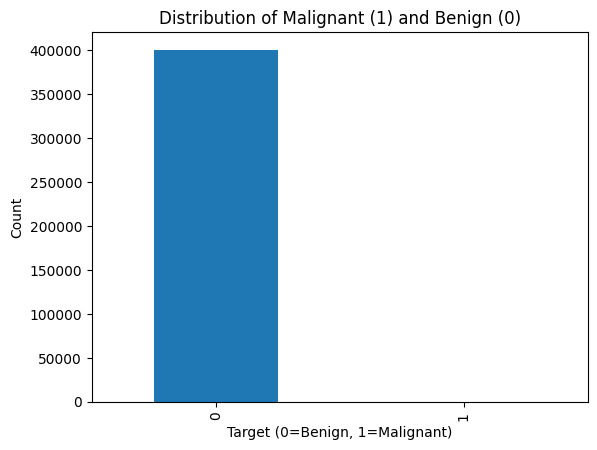

In [10]:
# target 값 분포 확인
print(metadata['target'].value_counts())

# 시각화
import matplotlib.pyplot as plt

metadata['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Malignant (1) and Benign (0)')
plt.xlabel('Target (0=Benign, 1=Malignant)')
plt.ylabel('Count')
plt.show()

In [11]:
# 데이터의 10% 샘플링 (클래스 비율 유지)
metadata_sampled = metadata.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42))

# 확인
print(f"Original data size: {len(metadata)}")
print(f"Sampled data size: {len(metadata_sampled)}")
print(metadata_sampled['target'].value_counts())

Original data size: 401059
Sampled data size: 40106
target
0    40067
1       39
Name: count, dtype: int64


<ipython-input-11-fbe449bdd92c>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metadata_sampled = metadata.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42))


In [12]:
from sklearn.model_selection import train_test_split

# 전체 데이터를 훈련(60%) 및 임시 데이터(40%)로 나누기
train_df, temp_df = train_test_split(metadata_sampled, test_size=0.4, stratify=metadata_sampled['target'], random_state=42)

# 임시 데이터를 검증(20%) 및 테스트(20%)로 나누기
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['target'], random_state=42)

# 분리된 데이터 크기 확인
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 24063
Validation set size: 8021
Test set size: 8022


In [ ]:
# 클래스 분포 확인
print("Training set class distribution:")
print(train_df['target'].value_counts())

print("\nValidation set class distribution:")
print(val_df['target'].value_counts())

print("\nTest set class distribution:")
print(test_df['target'].value_counts())

In [ ]:
# 데이터의 10% 샘플링 (클래스 비율 유지)
metadata_sampled = metadata.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42))

# 확인
print(f"Original data size: {len(metadata)}")
print(f"Sampled data size: {len(metadata_sampled)}")
print(metadata_sampled['target'].value_counts())

In [1]:
# 이미지 전처리 함수
def preprocess_image(img_path, target_size=128):
    img = load_img(img_path, target_size=(target_size, target_size))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    return img_array

# 데이터셋 생성 함수
def create_dataset(dataframe):
    images, labels = [], []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        img_array = preprocess_image(row['image_path'], target_size=128)
        images.append(img_array)
        labels.append(row['target'])
    return np.array(images), np.array(labels)

# 각 데이터셋 생성
train_images, train_labels = create_dataset(train_df)
val_images, val_labels = create_dataset(val_df)
test_images, test_labels = create_dataset(test_df)

# 확인
print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")


NameError: name 'train_df' is not defined

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import numpy as np
from tqdm import tqdm

# 데이터 로드
data_dir = '/content/extracted/train-image/image/'
csv_path = '/content/extracted/train_metadata_with_paths.csv'
metadata_path = os.path.join(data_dir, csv_path)
metadata = pd.read_csv(metadata_path)

# 데이터 샘플링 (10%)
metadata_sampled = metadata.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42))

print(f"Original data size: {len(metadata)}")
print(f"Sampled data size: {len(metadata_sampled)}")

# 데이터 분리
train_df, temp_df = train_test_split(metadata_sampled, test_size=0.4, stratify=metadata_sampled['target'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['target'], random_state=42)

# 이미지 전처리 함수
IMG_SIZE = 128
def preprocess_image(img_path, target_size=IMG_SIZE):
    img = load_img(img_path, target_size=(target_size, target_size))
    img_array = img_to_array(img) / 255.0
    return img_array

def create_dataset(dataframe):
    images, labels = [], []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        img_array = preprocess_image(row['image_path'], target_size=IMG_SIZE)
        images.append(img_array)
        labels.append(row['target'])
    return np.array(images), np.array(labels)

# 데이터셋 생성
train_images, train_labels = create_dataset(train_df)
val_images, val_labels = create_dataset(val_df)
test_images, test_labels = create_dataset(test_df)

# 원-핫 인코딩
train_labels_one_hot = to_categorical(train_labels, num_classes=2)
val_labels_one_hot = to_categorical(val_labels, num_classes=2)
test_labels_one_hot = to_categorical(test_labels, num_classes=2)

print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")


<ipython-input-4-ae55a887d5ac>:13: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_path)
<ipython-input-4-ae55a887d5ac>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metadata_sampled = metadata.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42))


Original data size: 401059
Sampled data size: 40106


100%|██████████| 8022/8022 [00:28<00:00, 278.31it/s]
